In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cred9593/val_data.npy
/kaggle/input/cred9593/dev_data.npy


# ANN Hyparameter Testing

In [2]:
from sklearn.metrics import classification_report, accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef,make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
# from keras_tuner.tuners import RandomSearch 
from keras_tuner.tuners import BayesianOptimization, RandomSearch
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_tuner
# Custom activation function
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras import backend as K
from tensorflow.keras.utils import get_custom_objects

In [3]:
data = np.load('/kaggle/input/cred9593/dev_data.npy')
X_val = np.load('/kaggle/input/cred9593/val_data.npy')
X = data.T[:-1].T
y = data.T[-1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, shuffle=True)

In [4]:
## Add leaky-relu so we can use it as a string
get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})

def build_model(hp):
    model = keras.Sequential()
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 20)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh","leaky-relu"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="sigmoid"))
    learning_rate = hp.Float("lr", min_value=1e-7, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

build_model(keras_tuner.HyperParameters())

In [5]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=50,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="tuner1",
)
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'leaky-relu'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-07, 'conditions': [], 'min_value': 1e-07, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [6]:
tuner.search(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_test, y_test))

Trial 50 Complete [00h 02m 34s]
val_accuracy: 0.9500871300697327

Best val_accuracy So Far: 0.9804838001728058
Total elapsed time: 02h 40m 12s


In [7]:
tuner.results_summary()
best_model = tuner.get_best_models()[0]
best_model.build(X_train.shape)
best_model.summary()
best_model.fit(X_train,y_train, verbose=1, epochs=250, batch_size=256, validation_data=(X_test, y_test))

Results summary
Results in my_dir/tuner1
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 8
units_0: 288
activation: relu
dropout: True
lr: 0.00014030388236345066
units_1: 384
units_2: 416
units_3: 64
units_4: 320
units_5: 448
units_6: 320
units_7: 32
units_8: 96
units_9: 160
units_10: 352
units_11: 192
units_12: 64
units_13: 416
units_14: 512
units_15: 192
units_16: 352
units_17: 160
units_18: 160
units_19: 224
Score: 0.9804838001728058
Trial summary
Hyperparameters:
num_layers: 18
units_0: 320
activation: relu
dropout: False
lr: 0.0004739050452585973
units_1: 480
units_2: 288
units_3: 224
units_4: 320
units_5: 352
units_6: 448
units_7: 224
units_8: 352
units_9: 288
units_10: 256
units_11: 96
units_12: 416
units_13: 288
units_14: 192
units_15: 96
units_16: 96
units_17: 256
units_18: 448
units_19: 352
Score: 0.9802461266517639
Trial summary
Hyperparameters:
num_layers: 5
units_0: 160
activation: leaky-relu
dropout: True
lr: 0.0002705603396024368
units_1: 416
units_2: 4

In [8]:
display(best_model.evaluate(X_test, y_test))
y_pred_nn = best_model.predict(X_test)
y_pred = (y_pred_nn > 0.5).astype(np.float32)
print("The model used is Artificial Neural Network")
acc= accuracy_score(y_test, y_pred)
print("The accuracy is  {}".format(acc))
prec= precision_score(y_test, y_pred)
print("The precision is {}".format(prec))
rec= recall_score(y_test, y_pred)
print("The recall is {}".format(rec))
f1= f1_score(y_test, y_pred)
print("The F1-Score is {}".format(f1))
MCC=matthews_corrcoef(y_test, y_pred)
print("The Matthews correlation coefficient is {}".format(MCC))
print(classification_report(y_test, y_pred))

592/592 [==============================] - 1s 2ms/step - loss: 0.0953 - accuracy: 0.9860


[0.09529368579387665, 0.9860032796859741]

592/592 [==============================] - 1s 2ms/step
The model used is Artificial Neural Network
The accuracy is  0.9860032747055406
The precision is 0.9742396027312229
The recall is 0.998303826990353
The F1-Score is 0.9861249280067018
The Matthews correlation coefficient is 0.9723031507529194
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99      9500
         1.0       0.97      1.00      0.99      9433

    accuracy                           0.99     18933
   macro avg       0.99      0.99      0.99     18933
weighted avg       0.99      0.99      0.99     18933



592/592 [==============================] - 1s 2ms/step


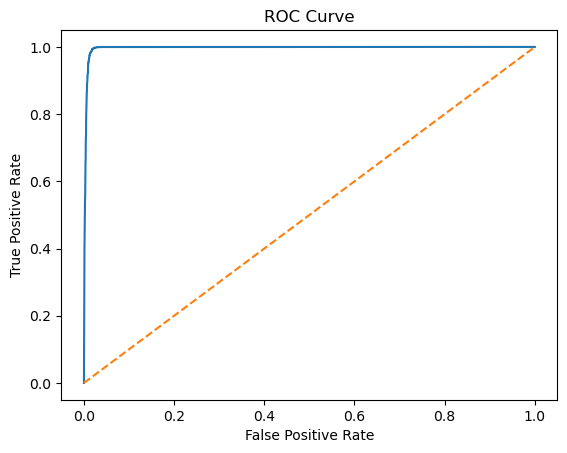

AUC score: 0.9968354600590312


In [9]:
probs_nn = best_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs_nn)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, probs_nn)
print('AUC score:', auc)

In [11]:
!mkdir -p saved_model
best_model.save("ANN_model.h5")